In [ ]:
import pandas as ad

In [7]:
df=pd.read_csv("dataset.csv")

,question_id,answer_id,title,question_body,answer_body,accepted_answer_id,answer_count,que_comment_count,ans_comment_count,community_owned_date,que_creation_date,ans_creation_date,favorite_count,last_activity_date,que_last_edit_date,ans_last_edit_date,last_editor_display_name,last_editor_user_id,owner_user_id,post_type_id,que_score,ans_score,que_tags,ans_tags,que_view_count
0,53851100.0,53851593,Hide/Collapse Image in RowDetailsTemplate,<p>I have a WPF/XAML DataGrid with a RowDetail...,<p>thanks to Clemens link the solution was to ...,NaN,1.0,2.0,0,None,2018-12-19 12:16:38.363000+00:00,2018-12-19 12:46:51.820000+00:00,NaN,2018-12-19 12:46:51.820000+00:00,2018-12-19 12:29:47.677000+00:00,NaT,,6064931.0,6064931.0,1.0,0.0,0,wpf|image|xaml|datagrid|rowdetailstemplate,,14.0
1,54147660.0,54148525,Why AddMvc expects Action<MvcOptions> instead ...,<p>I'm learning ASP.NET Core and I see that re...,"<p>If you look at the <a href=""https://github....",NaN,1.0,4.0,0,None,2019-01-11 13:38:31.230000+00:00,2019-01-11 14:30:18.260000+00:00,2.0,2019-02-23 17:23:59.930000+00:00,2019-01-11 13:49:36.767000+00:00,2019-01-15 11:51:59.800000+00:00,,243245.0,5021151.0,1.0,3.0,9,c#|asp.net-core,,204.0
2,53654178.0,53654241,Python Square Root for Class Instances,<p>I am currently implementing a class that ca...,<p>There's no trivial/out-of-the-box way to wi...,53654368.0,3.0,10.0,1,None,2018-12-06 15:00:25.170000+00:00,2018-12-06 15:04:03.873000+00:00,NaN,2018-12-06 15:24:54.890000+00:00,NaT,2018-12-06 15:13:57.113000+00:00,,NaN,9607187.0,1.0,2.0,2,python|magic-methods,,86.0
3,54273358.0,54281226,Converting first string letter to capital and ...,"<p>I started learning XSLT, kind of got stuck ...",<p>Could you have more than two delimiters in ...,NaN,2.0,3.0,5,None,2019-01-20 03:31:19.363000+00:00,2019-01-20 21:36:36.743000+00:00,NaN,2019-01-21 12:02:37.947000+00:00,2019-01-20 05:34:40.107000+00:00,2019-01-21 12:02:37.947000+00:00,,3016153.0,7945862.0,1.0,0.0,0,xslt|xslt-1.0,,110.0
4,54421796.0,54421921,Is using malloc within scanf compliant to c an...,<p>I want to read the input of a user and save...,<p>This will <strong>not</strong> work as you ...,54421921.0,3.0,14.0,0,None,2019-01-29 13:07:04.503000+00:00,2019-01-29 13:13:47.640000+00:00,NaN,2019-02-13 19:01:16.710000+00:00,2019-02-13 19:01:16.710000+00:00,2019-01-29 13:38:18.857000+00:00,,1687119.0,5732150.0,1.0,3.0,8,c|c89,,104.0


# Import the required libraries

In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, log_loss, roc_curve, auc, roc_auc_score
import math
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df.shape

(615859, 25)

In [10]:
df.columns

Index(['question_id', 'answer_id', 'title', 'question_body', 'answer_body',
       'accepted_answer_id', 'answer_count', 'que_comment_count',
       'ans_comment_count', 'community_owned_date', 'que_creation_date',
       'ans_creation_date', 'favorite_count', 'last_activity_date',
       'que_last_edit_date', 'ans_last_edit_date', 'last_editor_display_name',
       'last_editor_user_id', 'owner_user_id', 'post_type_id', 'que_score',
       'ans_score', 'que_tags', 'ans_tags', 'que_view_count'],
      dtype='object')

Check for the number of NAs in the dataset

In [11]:
print(df.isnull().sum().sum())
print(df.isnull().sum())

4115360
question_id                 115511
answer_id                        0
title                       115511
question_body               115511
answer_body                      0
accepted_answer_id          342972
answer_count                115511
que_comment_count           115511
ans_comment_count                0
community_owned_date        615859
que_creation_date           115511
ans_creation_date                0
favorite_count              553171
last_activity_date          115511
que_last_edit_date          327154
ans_last_edit_date          443036
last_editor_display_name    115511
last_editor_user_id         328330
owner_user_id               118706
post_type_id                115511
que_score                   115511
ans_score                        0
que_tags                    115511
ans_tags                         0
que_view_count              115511
dtype: int64


Drop the entries havin NA in  columns: 'que_creation_date',	'ans_creation_date', 'que_tags', 'question_id',	'answer_id', 'accepted_answer_id'

In [12]:
print(df.shape)
df=df.dropna(axis=0,subset=['que_creation_date',	'ans_creation_date', 'que_tags', 'question_id',	'answer_id', 'accepted_answer_id'])
print(df.shape)
print(df.isnull().sum().sum())

(615859, 25)
(272887, 25)
919721


Create a new column denoting the date difference between the questioncreation date and answer creation date

In [13]:
df1=df.loc[df.answer_id==df.accepted_answer_id,:].copy()
df1['answer_probability']=(df1.ans_creation_date - df1.que_creation_date).dt.days
print(df1.shape)
df1.head()

(181832, 26)


,question_id,answer_id,title,question_body,answer_body,accepted_answer_id,answer_count,que_comment_count,ans_comment_count,community_owned_date,que_creation_date,ans_creation_date,favorite_count,last_activity_date,que_last_edit_date,ans_last_edit_date,last_editor_display_name,last_editor_user_id,owner_user_id,post_type_id,que_score,ans_score,que_tags,ans_tags,que_view_count,answer_probability
4,54421796.0,54421921,Is using malloc within scanf compliant to c an...,<p>I want to read the input of a user and save...,<p>This will <strong>not</strong> work as you ...,54421921.0,3.0,14.0,0,None,2019-01-29 13:07:04.503000+00:00,2019-01-29 13:13:47.640000+00:00,NaN,2019-02-13 19:01:16.710000+00:00,2019-02-13 19:01:16.710000+00:00,2019-01-29 13:38:18.857000+00:00,,1687119.0,5732150.0,1.0,3.0,8,c|c89,,104.0,0
9,54817100.0,54935716,"SSL with Puma, HTTP parse error, malformed req...",<p>Attempting to configure Puma with HTTPS for...,<p><strong>Here is the solution that finally w...,54935716.0,2.0,13.0,0,None,2019-02-21 22:18:15.387000+00:00,2019-02-28 23:11:45.487000+00:00,NaN,2019-02-28 23:11:45.487000+00:00,2019-02-28 22:32:13.993000+00:00,NaT,,4044009.0,4044009.0,1.0,0.0,0,ruby-on-rails|ruby|puma,,118.0,7
15,54024503.0,54024619,Bootstrap collapsed navbar toggle not working,<p>The toggle button appears when window is re...,<p>You have added <code>navbar-collapse</code>...,54024619.0,1.0,3.0,0,None,2019-01-03 14:42:41.683000+00:00,2019-01-03 14:48:54.127000+00:00,NaN,2019-01-03 16:05:22.637000+00:00,2019-01-03 16:05:22.637000+00:00,2019-01-03 14:59:53.703000+00:00,,462627.0,10863160.0,1.0,2.0,0,jquery|html|css|twitter-bootstrap|twitter-boot...,,98.0,0
28,54778520.0,54778827,Mongo-Go-Driver Failing to Connect,"<p>So I am trying to use <a href=""https://gith...",<p>To those who come searching - the docs are ...,54778827.0,1.0,0.0,2,None,2019-02-20 03:47:18.923000+00:00,2019-02-20 04:24:47.647000+00:00,NaN,2019-02-20 04:24:47.647000+00:00,NaT,NaT,,NaN,7268968.0,1.0,0.0,1,database|mongodb|go|database-connection|mongo-go,,155.0,0
34,54231923.0,54233279,How to get selected item in RadioGroup in Reac...,<p>How can i get selected value from RadioGrou...,"<p>Install the <a href=""https://www.npmjs.com/...",54233279.0,2.0,4.0,0,None,2019-01-17 08:39:44.720000+00:00,2019-01-17 09:57:49.383000+00:00,NaN,2019-01-17 09:57:49.383000+00:00,NaT,NaT,,NaN,5821228.0,1.0,0.0,1,react-native,,80.0,0


If the date difference is less than 8 then probability is 1 else 0

In [14]:
for row in range(len(df1)):
  if df1.iloc[row,25]<=7:
    df1.iloc[row,25]=1
  else:
    df1.iloc[row,25]=0
df1.head()

,question_id,answer_id,title,question_body,answer_body,accepted_answer_id,answer_count,que_comment_count,ans_comment_count,community_owned_date,que_creation_date,ans_creation_date,favorite_count,last_activity_date,que_last_edit_date,ans_last_edit_date,last_editor_display_name,last_editor_user_id,owner_user_id,post_type_id,que_score,ans_score,que_tags,ans_tags,que_view_count,answer_probability
4,54421796.0,54421921,Is using malloc within scanf compliant to c an...,<p>I want to read the input of a user and save...,<p>This will <strong>not</strong> work as you ...,54421921.0,3.0,14.0,0,None,2019-01-29 13:07:04.503000+00:00,2019-01-29 13:13:47.640000+00:00,NaN,2019-02-13 19:01:16.710000+00:00,2019-02-13 19:01:16.710000+00:00,2019-01-29 13:38:18.857000+00:00,,1687119.0,5732150.0,1.0,3.0,8,c|c89,,104.0,1
9,54817100.0,54935716,"SSL with Puma, HTTP parse error, malformed req...",<p>Attempting to configure Puma with HTTPS for...,<p><strong>Here is the solution that finally w...,54935716.0,2.0,13.0,0,None,2019-02-21 22:18:15.387000+00:00,2019-02-28 23:11:45.487000+00:00,NaN,2019-02-28 23:11:45.487000+00:00,2019-02-28 22:32:13.993000+00:00,NaT,,4044009.0,4044009.0,1.0,0.0,0,ruby-on-rails|ruby|puma,,118.0,1
15,54024503.0,54024619,Bootstrap collapsed navbar toggle not working,<p>The toggle button appears when window is re...,<p>You have added <code>navbar-collapse</code>...,54024619.0,1.0,3.0,0,None,2019-01-03 14:42:41.683000+00:00,2019-01-03 14:48:54.127000+00:00,NaN,2019-01-03 16:05:22.637000+00:00,2019-01-03 16:05:22.637000+00:00,2019-01-03 14:59:53.703000+00:00,,462627.0,10863160.0,1.0,2.0,0,jquery|html|css|twitter-bootstrap|twitter-boot...,,98.0,1
28,54778520.0,54778827,Mongo-Go-Driver Failing to Connect,"<p>So I am trying to use <a href=""https://gith...",<p>To those who come searching - the docs are ...,54778827.0,1.0,0.0,2,None,2019-02-20 03:47:18.923000+00:00,2019-02-20 04:24:47.647000+00:00,NaN,2019-02-20 04:24:47.647000+00:00,NaT,NaT,,NaN,7268968.0,1.0,0.0,1,database|mongodb|go|database-connection|mongo-go,,155.0,1
34,54231923.0,54233279,How to get selected item in RadioGroup in Reac...,<p>How can i get selected value from RadioGrou...,"<p>Install the <a href=""https://www.npmjs.com/...",54233279.0,2.0,4.0,0,None,2019-01-17 08:39:44.720000+00:00,2019-01-17 09:57:49.383000+00:00,NaN,2019-01-17 09:57:49.383000+00:00,NaT,NaT,,NaN,5821228.0,1.0,0.0,1,react-native,,80.0,1


Create a dataset with equal number of instances of both the classes

In [15]:
dataset1=df1[df1.answer_probability==1].copy()
dataset2=df1[df1.answer_probability==0].copy()
print(dataset1.shape, dataset2.shape)

(177174, 26) (4658, 26)


In [16]:
dataset1=dataset1.sample(n=dataset2.shape[0], random_state=23).copy()
dataset1.shape

(4658, 26)

In [17]:
df1=dataset1.append(dataset2)
df1.shape

(9316, 26)

In [18]:
df1.shape

(9316, 26)

In [19]:
df1.dtypes

question_id                             float64
answer_id                                 int64
title                                    object
question_body                            object
answer_body                              object
accepted_answer_id                      float64
answer_count                            float64
que_comment_count                       float64
ans_comment_count                         int64
community_owned_date                     object
que_creation_date           datetime64[ns, UTC]
ans_creation_date           datetime64[ns, UTC]
favorite_count                          float64
last_activity_date          datetime64[ns, UTC]
que_last_edit_date          datetime64[ns, UTC]
ans_last_edit_date          datetime64[ns, UTC]
last_editor_display_name                 object
last_editor_user_id                     float64
owner_user_id                           float64
post_type_id                            float64
que_score                               

In [0]:
df1=df1.reset_index(drop=True)

Get all the unique que tags

In [21]:
d=set()
for row in range(len(df1)):
  if df1.loc[row,'que_tags']!=None:
    d=d.union(set(df1.loc[row,'que_tags'].split('|')))
que_tags_list=list(d)
print(len(d))

6250


In [0]:
df2=df1.copy()

Create the column for the que tags. Such that each column has one tag

In [23]:
df_que_tags=df1.que_tags.str.split("|",expand=True)
df1=df1.join(df_que_tags)
df1.head()

,question_id,answer_id,title,question_body,answer_body,accepted_answer_id,answer_count,que_comment_count,ans_comment_count,community_owned_date,que_creation_date,ans_creation_date,favorite_count,last_activity_date,que_last_edit_date,ans_last_edit_date,last_editor_display_name,last_editor_user_id,owner_user_id,post_type_id,que_score,ans_score,que_tags,ans_tags,que_view_count,answer_probability,0,1,2,3,4
0,54309882.0,54310514,What initializer called in convenience init of...,<p>I often use convenience init in <code>UIVie...,<p><code>UIViewController.init</code> calls <c...,54310514.0,3.0,0.0,1,None,2019-01-22 13:56:05.640000+00:00,2019-01-22 14:32:47.990000+00:00,0.0,2019-01-22 14:35:33.357000+00:00,2019-01-22 14:35:33.357000+00:00,NaT,,8584103.0,8584103.0,1.0,2.0,3,swift|uiviewcontroller|initializer,,58.0,1,swift,uiviewcontroller,initializer,None,None
1,54461342.0,54461778,Is there any way to undertake rounding with cu...,<p>I'm wondering if there's any way to round u...,<p>You could just offset the numbers before ro...,54461778.0,2.0,2.0,3,None,2019-01-31 13:08:31.177000+00:00,2019-01-31 13:33:46.057000+00:00,NaN,2019-01-31 13:48:36.657000+00:00,2019-01-31 13:31:41.287000+00:00,2019-01-31 13:45:52.590000+00:00,,680068.0,10216999.0,1.0,0.0,1,r|datetime|rounding,,60.0,1,r,datetime,rounding,None,None
2,54565705.0,54565857,How to lower cyclomatic complexity of switch w...,<p>I have to check if a value is withing a ran...,<p>You can just use integer division if the nu...,54565857.0,2.0,3.0,0,None,2019-02-07 03:04:00.360000+00:00,2019-02-07 03:27:23.937000+00:00,NaN,2019-02-07 03:31:25.990000+00:00,2019-02-07 03:29:32.697000+00:00,NaT,,3741589.0,2224904.0,1.0,0.0,0,php|cyclomatic-complexity,,40.0,1,php,cyclomatic-complexity,None,None,None
3,54405559.0,54406182,AWS Role being assumed not being used for futu...,<p>I am trying to assume a role in a docker co...,<p>Calling <code>assume-role</code> is not goi...,54406182.0,1.0,0.0,3,None,2019-01-28 15:45:36.587000+00:00,2019-01-28 16:19:11.243000+00:00,NaN,2019-01-28 16:19:11.243000+00:00,2019-01-28 15:52:26.340000+00:00,NaT,,4763754.0,4763754.0,1.0,1.0,2,amazon-web-services|aws-cli,,25.0,1,amazon-web-services,aws-cli,None,None,None
4,53926163.0,53927573,generate public and private Keys in Hexadecima...,<p>I want please to generate the public and th...,<p>It doesn't seem like you are actually creat...,53927573.0,1.0,2.0,1,None,2018-12-25 23:05:23.707000+00:00,2018-12-26 04:55:30.143000+00:00,NaN,2018-12-28 19:17:29.337000+00:00,2018-12-28 19:17:29.337000+00:00,2018-12-26 15:19:59.957000+00:00,,5759687.0,5759687.0,1.0,0.0,4,java,,72.0,1,java,None,None,None,None


Replace date column with the date difference

In [24]:
df1.last_activity_date=(df1.last_activity_date - df1.que_creation_date).dt.days
df1.que_last_edit_date=(df1.que_last_edit_date - df1.que_creation_date).dt.days
df1.ans_last_edit_date=(df1.ans_last_edit_date - df1.ans_creation_date).dt.days
df1.head()

,question_id,answer_id,title,question_body,answer_body,accepted_answer_id,answer_count,que_comment_count,ans_comment_count,community_owned_date,que_creation_date,ans_creation_date,favorite_count,last_activity_date,que_last_edit_date,ans_last_edit_date,last_editor_display_name,last_editor_user_id,owner_user_id,post_type_id,que_score,ans_score,que_tags,ans_tags,que_view_count,answer_probability,0,1,2,3,4
0,54309882.0,54310514,What initializer called in convenience init of...,<p>I often use convenience init in <code>UIVie...,<p><code>UIViewController.init</code> calls <c...,54310514.0,3.0,0.0,1,None,2019-01-22 13:56:05.640000+00:00,2019-01-22 14:32:47.990000+00:00,0.0,0,0.0,NaN,,8584103.0,8584103.0,1.0,2.0,3,swift|uiviewcontroller|initializer,,58.0,1,swift,uiviewcontroller,initializer,None,None
1,54461342.0,54461778,Is there any way to undertake rounding with cu...,<p>I'm wondering if there's any way to round u...,<p>You could just offset the numbers before ro...,54461778.0,2.0,2.0,3,None,2019-01-31 13:08:31.177000+00:00,2019-01-31 13:33:46.057000+00:00,NaN,0,0.0,0.0,,680068.0,10216999.0,1.0,0.0,1,r|datetime|rounding,,60.0,1,r,datetime,rounding,None,None
2,54565705.0,54565857,How to lower cyclomatic complexity of switch w...,<p>I have to check if a value is withing a ran...,<p>You can just use integer division if the nu...,54565857.0,2.0,3.0,0,None,2019-02-07 03:04:00.360000+00:00,2019-02-07 03:27:23.937000+00:00,NaN,0,0.0,NaN,,3741589.0,2224904.0,1.0,0.0,0,php|cyclomatic-complexity,,40.0,1,php,cyclomatic-complexity,None,None,None
3,54405559.0,54406182,AWS Role being assumed not being used for futu...,<p>I am trying to assume a role in a docker co...,<p>Calling <code>assume-role</code> is not goi...,54406182.0,1.0,0.0,3,None,2019-01-28 15:45:36.587000+00:00,2019-01-28 16:19:11.243000+00:00,NaN,0,0.0,NaN,,4763754.0,4763754.0,1.0,1.0,2,amazon-web-services|aws-cli,,25.0,1,amazon-web-services,aws-cli,None,None,None
4,53926163.0,53927573,generate public and private Keys in Hexadecima...,<p>I want please to generate the public and th...,<p>It doesn't seem like you are actually creat...,53927573.0,1.0,2.0,1,None,2018-12-25 23:05:23.707000+00:00,2018-12-26 04:55:30.143000+00:00,NaN,2,2.0,0.0,,5759687.0,5759687.0,1.0,0.0,4,java,,72.0,1,java,None,None,None,None


In [25]:
df1.dtypes

question_id                             float64
answer_id                                 int64
title                                    object
question_body                            object
answer_body                              object
accepted_answer_id                      float64
answer_count                            float64
que_comment_count                       float64
ans_comment_count                         int64
community_owned_date                     object
que_creation_date           datetime64[ns, UTC]
ans_creation_date           datetime64[ns, UTC]
favorite_count                          float64
last_activity_date                        int64
que_last_edit_date                      float64
ans_last_edit_date                      float64
last_editor_display_name                 object
last_editor_user_id                     float64
owner_user_id                           float64
post_type_id                            float64
que_score                               

Replace numerical columns with 0 and tag columns with "no tag"

In [26]:
print(df1.isnull().sum().sum())
df1.loc[:,['favorite_count','que_last_edit_date','ans_last_edit_date']]=df1.loc[:,['favorite_count','que_last_edit_date','ans_last_edit_date']].fillna(0,inplace=False)
df1.loc[:,[1,2,3,4]]=df1.loc[:,[1,2,3,4]].fillna('no tag',inplace=False)
print(df1.isnull().sum().sum())
print(df1.isnull().sum())

50569
13468
question_id                    0
answer_id                      0
title                          0
question_body                  0
answer_body                    0
accepted_answer_id             0
answer_count                   0
que_comment_count              0
ans_comment_count              0
community_owned_date        9316
que_creation_date              0
ans_creation_date              0
favorite_count                 0
last_activity_date             0
que_last_edit_date             0
ans_last_edit_date             0
last_editor_display_name       0
last_editor_user_id         4107
owner_user_id                 45
post_type_id                   0
que_score                      0
ans_score                      0
que_tags                       0
ans_tags                       0
que_view_count                 0
answer_probability             0
0                              0
1                              0
2                              0
3                              

Drop the useless columns

In [27]:
df1=df1.drop(axis=1,labels=['community_owned_date', 'last_editor_user_id', 'owner_user_id', 'post_type_id', 'que_creation_date', 'ans_creation_date', 'que_tags', 'question_id',	'answer_id', 'accepted_answer_id', 'ans_tags'])
print(df1.shape)
print(df1.isnull().sum())

(9316, 20)
title                       0
question_body               0
answer_body                 0
answer_count                0
que_comment_count           0
ans_comment_count           0
favorite_count              0
last_activity_date          0
que_last_edit_date          0
ans_last_edit_date          0
last_editor_display_name    0
que_score                   0
ans_score                   0
que_view_count              0
answer_probability          0
0                           0
1                           0
2                           0
3                           0
4                           0
dtype: int64


Assign each tag a number

In [28]:
encoder=LabelEncoder()
encoder.fit(que_tags_list+['no tag'])
df1[0]=encoder.transform(df1[0])
df1[1]=encoder.transform(df1[1])
df1[2]=encoder.transform(df1[2])
df1[3]=encoder.transform(df1[3])
df1[4]=encoder.transform(df1[4])
df1.head()

,title,question_body,answer_body,answer_count,que_comment_count,ans_comment_count,favorite_count,last_activity_date,que_last_edit_date,ans_last_edit_date,last_editor_display_name,que_score,ans_score,que_view_count,answer_probability,0,1,2,3,4
0,What initializer called in convenience init of...,<p>I often use convenience init in <code>UIVie...,<p><code>UIViewController.init</code> calls <c...,3.0,0.0,1,0.0,0,0.0,0.0,,2.0,3,58.0,1,5400,5759,2699,3721,3721
1,Is there any way to undertake rounding with cu...,<p>I'm wondering if there's any way to round u...,<p>You could just offset the numbers before ro...,2.0,2.0,3,0.0,0,0.0,0.0,,0.0,1,60.0,1,4475,1443,4741,3721,3721
2,How to lower cyclomatic complexity of switch w...,<p>I have to check if a value is withing a ran...,<p>You can just use integer division if the nu...,2.0,3.0,0,0.0,0,0.0,0.0,,0.0,0,40.0,1,4100,1363,3721,3721,3721
3,AWS Role being assumed not being used for futu...,<p>I am trying to assume a role in a docker co...,<p>Calling <code>assume-role</code> is not goi...,1.0,0.0,3,0.0,0,0.0,0.0,,1.0,2,25.0,1,161,620,3721,3721,3721
4,generate public and private Keys in Hexadecima...,<p>I want please to generate the public and th...,<p>It doesn't seem like you are actually creat...,1.0,2.0,1,0.0,2,2.0,0.0,,0.0,4,72.0,1,2819,3721,3721,3721,3721


Download the required nltk libraries

In [29]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

define functions for parsing html, stopword removal, lemmitization

In [0]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return re.sub(r'[^\w\s]', '', re.sub('\[[^]]*\]', '', soup.get_text()).lower()).split()

def remove_stopwords(words, language='english'):
    new_words = []
    for word in words:
        if word not in stopwords.words(language):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return ' '.join(lemmas)

In [0]:
def preprocess(text):
  return lemmatize_verbs(remove_stopwords(strip_html(text)))


Apply the function to text columns

In [32]:
df1.question_body=df1.question_body.map(preprocess)
print("done")
df1.title=df1.title.map(preprocess)
print("done")
df1.answer_body=df1.answer_body.map(preprocess)

done
done


Use Tfidf encoding to convert text to numbers

In [0]:
vectorizer=TfidfVectorizer(max_features=20, strip_accents='unicode')
title_data=vectorizer.fit_transform(df1['title'])
que_data=vectorizer.fit_transform(df1['question_body'])
ans_data=vectorizer.fit_transform(df1['answer_body'])

In [0]:
title_cols=["title_"+str(i) for i in range(20)]
que_cols=["que_"+str(i) for i in range(20)]
ans_cols=["ans_"+str(i) for i in range(20)]

Joining the dataset with the textual features

In [35]:
df1=df1.reset_index(drop=True)
dataset=df1.join(pd.DataFrame(title_data.toarray(),columns=title_cols))
dataset=dataset.join(pd.DataFrame(que_data.toarray(),columns=que_cols))
dataset=dataset.join(pd.DataFrame(ans_data.toarray(),columns=ans_cols))
dataset.shape

(9316, 80)

Remove the columns which are not required

In [36]:
dataset=dataset.drop(axis=1,labels=['title','question_body', 'answer_body', 'last_editor_display_name', 'ans_last_edit_date'])
print(dataset.shape)

(9316, 75)


In [37]:
dataset3=dataset.copy()
dataset3.shape

(9316, 75)

Create the training and validation set

In [38]:
X_train, X_test, Y_train, Y_test=train_test_split(dataset3.drop('answer_probability', axis=1),dataset3['answer_probability'], random_state=23, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(7452, 74) (1864, 74) (7452,) (1864,)


Use the random forest classifier and determine the accuracy using the ROC curve

Traing Accuracy= 1.0
Validation Accuracy= 0.9892703862660944
0.9893390191897655


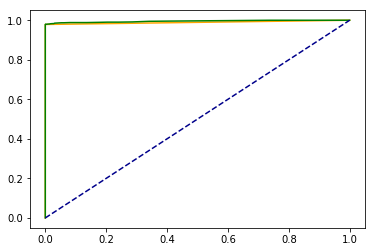

In [39]:
model=RandomForestClassifier(n_estimators=100, n_jobs=5)
model.fit(X_train, Y_train)
print("Traing Accuracy=",model.score(X_train, Y_train))
print("Validation Accuracy=",model.score(X_test, Y_test))
auc = roc_auc_score(Y_test, model.predict(X_test))
print(auc)
fpr, tpr, thresholds = roc_curve(Y_test, model.predict(X_test))
plt.plot(fpr, tpr, color='orange', label='ROC')
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.show()

Model #2 : without using any of the answer features/details

In [40]:
dataset=df1.join(pd.DataFrame(title_data.toarray(),columns=title_cols))
dataset=dataset.join(pd.DataFrame(que_data.toarray(),columns=que_cols))
dataset.shape

(9316, 60)

delete the colmns which are not required

In [41]:
dataset=dataset.drop(axis=1,labels=['title','question_body', 'answer_body', 'last_editor_display_name', 'ans_last_edit_date','answer_count', 'ans_comment_count', 'ans_score'])
print(dataset.shape)

(9316, 52)


In [42]:
dataset3=dataset.copy()
dataset3.shape

(9316, 52)

Training and validation set

In [43]:
X_train, X_test, Y_train, Y_test=train_test_split(dataset3.drop('answer_probability', axis=1),dataset3['answer_probability'], random_state=23, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(7452, 51) (1864, 51) (7452,) (1864,)


Using random forest for predicting he probabilities

Traing Accuracy= 1.0
Validation Accuracy= 0.9892703862660944
0.9893390191897655


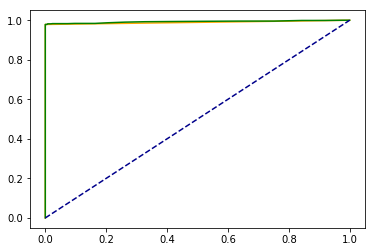

In [44]:
model=RandomForestClassifier(n_estimators=100, n_jobs=5)
model.fit(X_train, Y_train)
print("Traing Accuracy=",model.score(X_train, Y_train))
print("Validation Accuracy=",model.score(X_test, Y_test))
auc = roc_auc_score(Y_test, model.predict(X_test))
print(auc)
fpr, tpr, thresholds = roc_curve(Y_test, model.predict(X_test))
plt.plot(fpr, tpr, color='orange', label='ROC')
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.show()

Final validation probabilities

In [45]:
model.predict_proba(X_test)[:,1]

array([0.07, 0.92, 0.05, ..., 0.15, 0.1 , 0.13])